# Gas Prices prediction With LSTM model

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import random as rnd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler


## Read and check values, price distributions

In [ ]:
df=pd.read_csv('/content/oil_and_gas.csv')

In [ ]:
df

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,2000-01-04,23.9000,24.7000,23.8900,24.3900,32509,USD
1,Brent Oil,2000-01-05,24.2500,24.3700,23.7000,23.7300,30310,USD
2,Brent Oil,2000-01-06,23.5500,24.2200,23.3500,23.6200,44662,USD
3,Brent Oil,2000-01-07,23.5700,23.9800,23.0500,23.0900,34826,USD
4,Brent Oil,2000-01-10,23.0400,23.7800,23.0400,23.7300,26388,USD
...,...,...,...,...,...,...,...,...
22999,Heating Oil,2022-06-06,4.3026,4.4084,4.2565,4.3601,45144,USD
23000,Heating Oil,2022-06-07,4.3877,4.4025,4.2466,4.3206,50479,USD
23001,Heating Oil,2022-06-08,4.3177,4.3512,4.2800,4.3143,47557,USD
23002,Heating Oil,2022-06-09,4.3319,4.4667,4.2529,4.4037,46599,USD


In [ ]:
df.isnull().sum()

Symbol      0
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


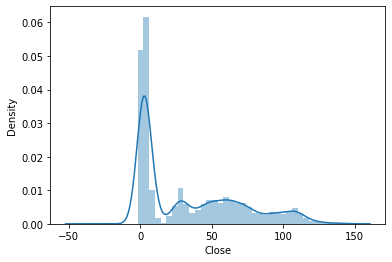

In [ ]:
sns.distplot(df['Close']);

In [ ]:
df["Changes"] = df["Close"]/df["Open"]* 100-100

In [ ]:
df=df.sort_values('Date')
df

,Symbol,Date,Open,High,Low,Close,Volume,Currency,Changes
0,Brent Oil,2000-01-04,23.9000,24.7000,23.8900,24.3900,32509,USD,2.050209
11502,Natural Gas,2000-01-04,2.1300,2.2000,2.1300,2.1760,30152,USD,2.159624
17239,Heating Oil,2000-01-04,0.6720,0.6830,0.6540,0.6778,25311,USD,0.863095
5763,Crude Oil WTI,2000-01-04,25.2000,25.6900,24.7100,25.5500,74788,USD,1.388889
1,Brent Oil,2000-01-05,24.2500,24.3700,23.7000,23.7300,30310,USD,-2.144330
...,...,...,...,...,...,...,...,...,...
5761,Brent Oil,2022-06-09,123.6000,124.3400,122.5000,123.0700,218983,USD,-0.428803
11501,Crude Oil WTI,2022-06-10,121.4600,122.7500,118.3300,120.6700,0,USD,-0.650420
5762,Brent Oil,2022-06-10,122.8900,124.3300,119.8100,122.0100,294278,USD,-0.716088
17238,Natural Gas,2022-06-10,8.9970,9.1490,8.6220,8.8500,0,USD,-1.633878


In [ ]:
df.Currency.nunique()

1

In [ ]:
df=df.drop(['Open','Low','High','Currency','Close','Volume'],axis=1, errors='ignore')
df

,Symbol,Date,Changes
0,Brent Oil,2000-01-04,2.050209
11502,Natural Gas,2000-01-04,2.159624
17239,Heating Oil,2000-01-04,0.863095
5763,Crude Oil WTI,2000-01-04,1.388889
1,Brent Oil,2000-01-05,-2.144330
...,...,...,...
5761,Brent Oil,2022-06-09,-0.428803
11501,Crude Oil WTI,2022-06-10,-0.650420
5762,Brent Oil,2022-06-10,-0.716088
17238,Natural Gas,2022-06-10,-1.633878


## Separate the dataframe for every Oil then transform and visualize price changes

In [ ]:
grouped = df.groupby(df.Symbol)

In [ ]:
print(df.Symbol.nunique())
print(df.Symbol.value_counts())

4
Heating Oil      5765
Brent Oil        5763
Crude Oil WTI    5739
Natural Gas      5737
Name: Symbol, dtype: int64


In [ ]:
Brent_Oil = grouped.get_group("Brent Oil")
Heating_Oil = grouped.get_group("Heating Oil")
Crude_Oil_WTI = grouped.get_group("Crude Oil WTI")
Natural_Gas = grouped.get_group("Natural Gas")

In [ ]:
print(len(Brent_Oil))
print(len(Heating_Oil))
print(len(Crude_Oil_WTI))
print(len(Natural_Gas))

5763
5765
5739
5737


In [ ]:
Brent_Oil = Brent_Oil.drop('Symbol',axis=1,errors='ignore')
Heating_Oil = Heating_Oil.drop('Symbol',axis=1,errors='ignore')
Crude_Oil_WTI = Crude_Oil_WTI.drop('Symbol',axis=1,errors='ignore')
Natural_Gas = Natural_Gas.drop('Symbol',axis=1,errors='ignore')

Brent_Oil=Brent_Oil.rename(columns={"Changes":"Brent_Oil"}).reset_index(drop=True)
Heating_Oil=Heating_Oil.rename(columns={"Changes":"Heating_Oil"}).reset_index(drop=True)
Crude_Oil_WTI=Crude_Oil_WTI.rename(columns={"Changes":"Crude_Oil_WTI"}).reset_index(drop=True)
Natural_Gas=Natural_Gas.rename(columns={"Changes":"Natural_Gas"}).reset_index(drop=True)

In [ ]:
Brent_Oil = Brent_Oil.drop('index',axis=1,errors='ignore')
Heating_Oil = Heating_Oil.drop('index',axis=1,errors='ignore')
Crude_Oil_WTI = Crude_Oil_WTI.drop('index',axis=1,errors='ignore')
Natural_Gas = Natural_Gas.drop('index',axis=1,errors='ignore')

In [ ]:
from datetime import datetime
Brent_Oil['Date'] =  pd.to_datetime(Brent_Oil['Date'])
Brent_Oil_resample=Brent_Oil.resample('Y', on='Date').Brent_Oil.sum()

Heating_Oil['Date'] =  pd.to_datetime(Heating_Oil['Date'])
Heating_Oil_resample = Heating_Oil.resample('Y', on='Date').Heating_Oil.sum()

Crude_Oil_WTI['Date'] =  pd.to_datetime(Crude_Oil_WTI['Date'])
Crude_Oil_WTI_resample = Crude_Oil_WTI.resample('Y', on='Date').Crude_Oil_WTI.sum()

Natural_Gas['Date'] =  pd.to_datetime(Natural_Gas['Date'])
Natural_Gas_resample = Natural_Gas.resample('Y', on='Date').Natural_Gas.sum()

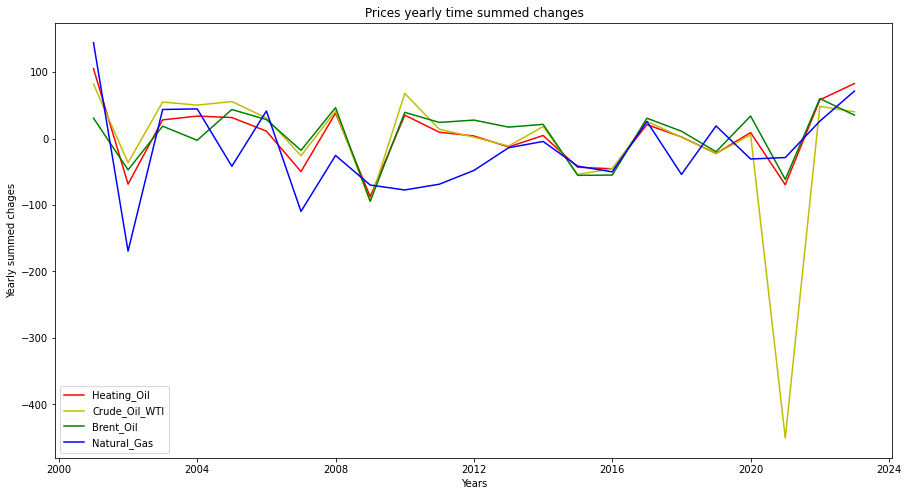

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
plt.figure(figsize=(15, 8))
plt.plot(Heating_Oil_resample, color='r', label='Heating_Oil')
plt.plot(Crude_Oil_WTI_resample, color='y', label='Crude_Oil_WTI')
plt.plot(Brent_Oil_resample, color='g', label='Brent_Oil')
plt.plot(Natural_Gas_resample, color='b', label='Natural_Gas')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Years")
plt.ylabel("Yearly summed chages")
plt.title("Prices yearly time summed changes")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the

## Merge transformed datas for check is there is correlation between price changes

In [ ]:
gas_prices = pd.concat([Brent_Oil,Heating_Oil,Crude_Oil_WTI,Natural_Gas], axis=1).reset_index(drop=True)

In [ ]:
gas_prices

,Date,Brent_Oil,Date,Heating_Oil,Date,Crude_Oil_WTI,Date,Natural_Gas
0,2000-01-04,2.050209,2000-01-04,0.863095,2000-01-04,1.388889,2000-01-04,2.159624
1,2000-01-05,-2.144330,2000-01-05,-1.988218,2000-01-05,-2.313725,2000-01-05,-0.550459
2,2000-01-06,0.297240,2000-01-06,-0.255831,2000-01-06,-0.080645,2000-01-06,1.431871
3,2000-01-07,-2.036487,2000-01-07,-1.893939,2000-01-07,-1.744422,2000-01-07,-1.002278
4,2000-01-10,2.994792,2000-01-10,0.418929,2000-01-10,1.857969,2000-01-10,1.651376
...,...,...,...,...,...,...,...,...
5760,2022-06-08,2.428512,2022-06-06,1.336401,NaT,NaN,NaT,NaN
5761,2022-06-09,-0.428803,2022-06-07,-1.529275,NaT,NaN,NaT,NaN
5762,2022-06-10,-0.716088,2022-06-08,-0.078746,NaT,NaN,NaT,NaN
5763,NaT,NaN,2022-06-09,1.657471,NaT,NaN,NaT,NaN


In [ ]:
gas_prices=gas_prices.dropna()

In [ ]:
gas_prices

,Date,Brent_Oil,Date,Heating_Oil,Date,Crude_Oil_WTI,Date,Natural_Gas
0,2000-01-04,2.050209,2000-01-04,0.863095,2000-01-04,1.388889,2000-01-04,2.159624
1,2000-01-05,-2.144330,2000-01-05,-1.988218,2000-01-05,-2.313725,2000-01-05,-0.550459
2,2000-01-06,0.297240,2000-01-06,-0.255831,2000-01-06,-0.080645,2000-01-06,1.431871
3,2000-01-07,-2.036487,2000-01-07,-1.893939,2000-01-07,-1.744422,2000-01-07,-1.002278
4,2000-01-10,2.994792,2000-01-10,0.418929,2000-01-10,1.857969,2000-01-10,1.651376
...,...,...,...,...,...,...,...,...
5732,2022-04-29,1.664342,2022-04-28,9.672184,2022-06-02,1.803136,2022-06-06,6.537143
5733,2022-05-02,1.204139,2022-04-29,-2.974657,2022-06-03,1.122926,2022-06-07,-0.705204
5734,2022-05-03,-2.453304,2022-05-02,5.280421,2022-06-06,-1.920212,2022-06-08,-6.813069
5735,2022-05-04,3.993957,2022-05-03,-4.274326,2022-06-07,0.260285,2022-06-09,3.870669


### There is no relevant correlation between prices

In [ ]:
gas_prices.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None)

,Brent_Oil,Heating_Oil,Crude_Oil_WTI,Natural_Gas
Brent_Oil,1.0,0.026,0.01,0.011
Heating_Oil,0.026,1.0,0.15,0.14
Crude_Oil_WTI,0.01,0.15,1.0,0.045
Natural_Gas,0.011,0.14,0.045,1.0


In [ ]:
gas_prices

,Date,Brent_Oil,Date,Heating_Oil,Date,Crude_Oil_WTI,Date,Natural_Gas
0,2000-01-04,2.050209,2000-01-04,0.863095,2000-01-04,1.388889,2000-01-04,2.159624
1,2000-01-05,-2.144330,2000-01-05,-1.988218,2000-01-05,-2.313725,2000-01-05,-0.550459
2,2000-01-06,0.297240,2000-01-06,-0.255831,2000-01-06,-0.080645,2000-01-06,1.431871
3,2000-01-07,-2.036487,2000-01-07,-1.893939,2000-01-07,-1.744422,2000-01-07,-1.002278
4,2000-01-10,2.994792,2000-01-10,0.418929,2000-01-10,1.857969,2000-01-10,1.651376
...,...,...,...,...,...,...,...,...
5732,2022-04-29,1.664342,2022-04-28,9.672184,2022-06-02,1.803136,2022-06-06,6.537143
5733,2022-05-02,1.204139,2022-04-29,-2.974657,2022-06-03,1.122926,2022-06-07,-0.705204
5734,2022-05-03,-2.453304,2022-05-02,5.280421,2022-06-06,-1.920212,2022-06-08,-6.813069
5735,2022-05-04,3.993957,2022-05-03,-4.274326,2022-06-07,0.260285,2022-06-09,3.870669


# Predict the Brent Oil prices

In [ ]:
Brent_Oil
Brent_Oil_data = Brent_Oil.filter(['Brent_Oil'])
Brent_Oil_data
dataset = Brent_Oil_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)


3975/3975 [==============================] - 115s 28ms/step - loss: 0.0032


In [ ]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

2.447541340583802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


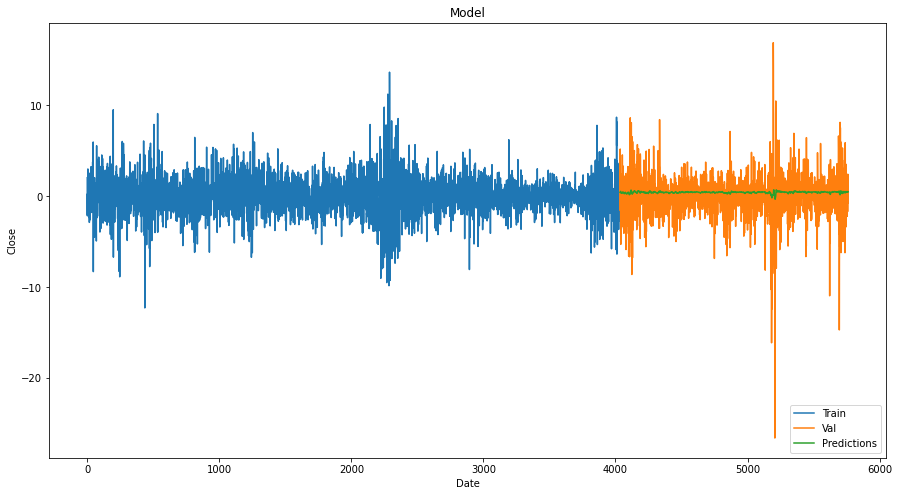

In [ ]:
plt.figure(figsize=(15, 8))
train = Brent_Oil[:training_data_len]
valid = Brent_Oil[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['Brent_Oil'])
plt.plot(valid[['Brent_Oil', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()

# Predict Natural Gas prices

In [ ]:
Natural_Gas
Natural_Gas_data = Natural_Gas.filter(['Natural_Gas'])
Natural_Gas_data
dataset = Natural_Gas_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]
 
# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training s and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

3956/3956 [==============================] - 103s 25ms/step - loss: 0.0040


In [ ]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

2.887940024778071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


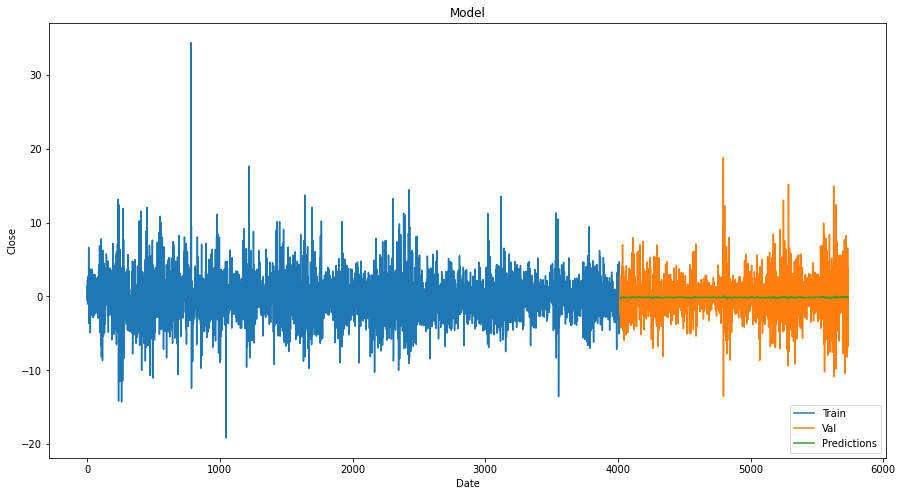

In [ ]:
plt.figure(figsize=(15, 8))
train = Natural_Gas[:training_data_len]
valid = Natural_Gas[training_data_len:]
 
valid['Predictions'] = predictions
 
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(train['Natural_Gas'])
plt.plot(valid[['Natural_Gas', 'Predictions']])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
 
plt.show()